# 自動車の評価値の分類 (One-Hotデータ処理 + DNNによる多値分類例)

In [1]:
outputname = 'DNN_One-Hot'

epochs = 1000
earlystep = 50
batch_size = 1024
validation_split = 0.2
dropratio = 0.1
learning_rate = 0.01

## ColaboratoryならばGoogle Drive のマウント
アカウントの指定、セキュリティの許可を行う

In [2]:
import sys
moduleList = sys.modules
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    datadir = '/content/drive/MyDrive/Colab Notebooks/car'
    tmpdir = '.'
else:
    datadir = '.'
    tmpdir = '.'

Mounted at /content/drive


# トレーニングデータの準備
## TSV形式ファイルの読み込みと確認

In [3]:
import numpy as np
import pandas as pd

train = pd.read_csv(f"{datadir}/train.tsv", sep="\t")
train

,id,class,buying,maint,doors,persons,lug_boot,safety
0,0,unacc,low,med,3,2,small,low
1,3,acc,low,high,3,more,small,med
2,7,unacc,vhigh,high,5more,2,small,med
3,11,acc,high,high,3,more,big,med
4,12,unacc,high,high,3,2,med,high
...,...,...,...,...,...,...,...,...
859,1721,acc,high,high,5more,more,med,med
860,1722,unacc,high,high,5more,4,small,med
861,1724,unacc,high,low,3,more,med,low
862,1725,unacc,low,low,5more,2,small,med


## まずデータを眺めてみる

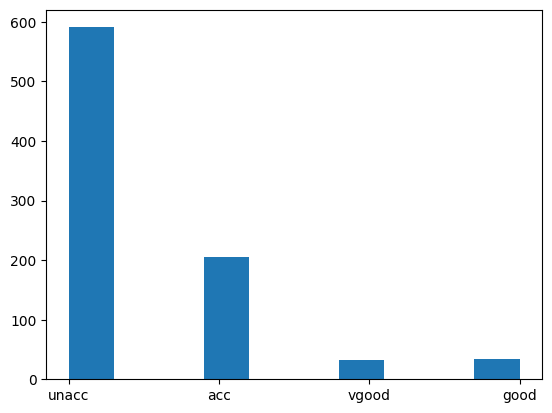

In [4]:
import matplotlib.pyplot as plt

plt.hist(train['class'])
plt.show()

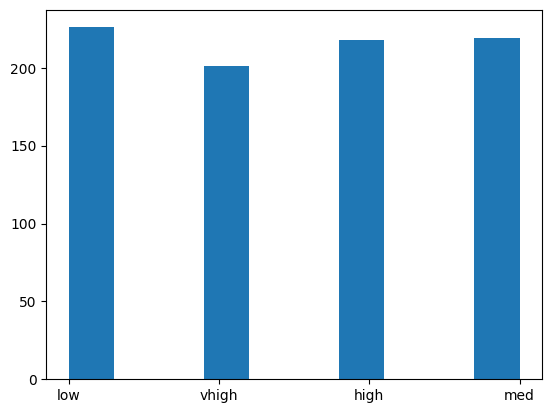

In [5]:
plt.hist(train['buying'])
plt.show()

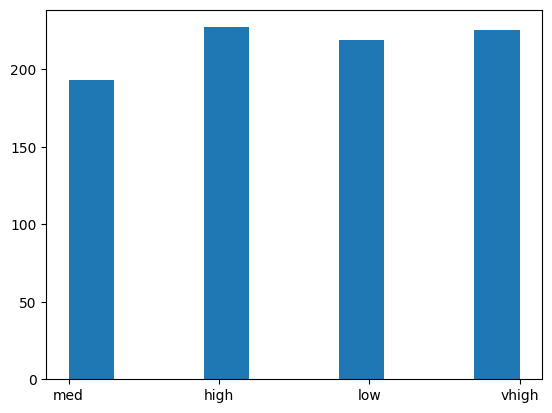

In [6]:
plt.hist(train['maint'])
plt.show()

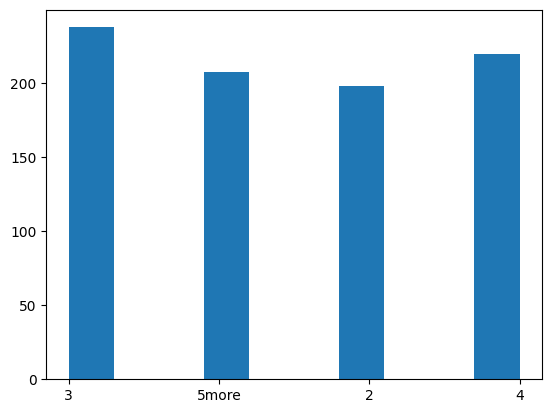

In [7]:
plt.hist(train['doors'])
plt.show()

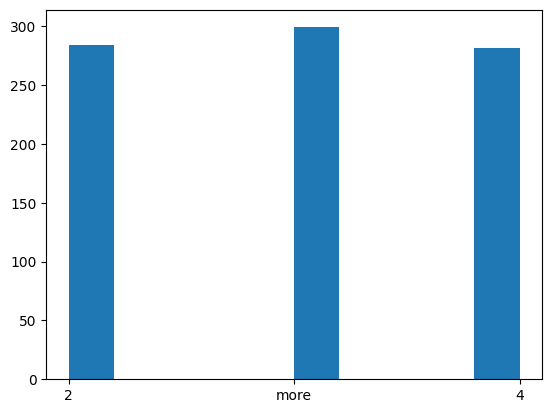

In [8]:
plt.hist(train['persons'])
plt.show()

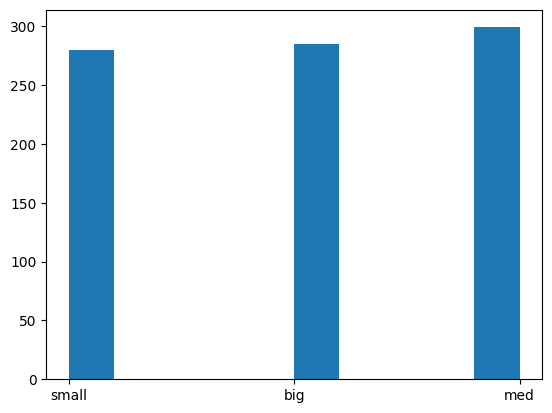

In [9]:
plt.hist(train['lug_boot'])
plt.show()

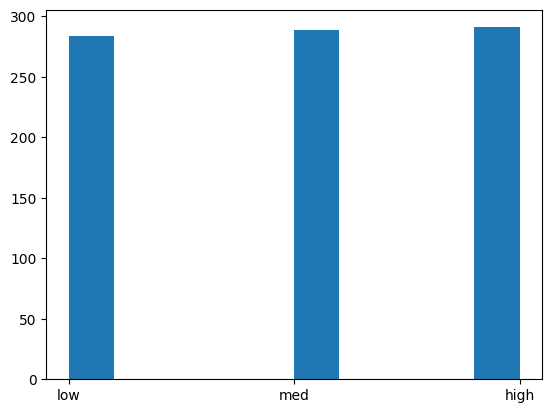

In [10]:
plt.hist(train['safety'])
plt.show()

目的変数には偏りがあるようだが、その他のパラメータはだいたいまんべんなく散っているようなので、データをあえて水増ししたりする必要は無いかもしれない。目的変数の数が同じになるように重複データを作ってあげると、偏見がないモデルを作ることもできる

## データを文字から数値へ変換
各パラメータを数値化する。trainもtestも同じデータ変換ができるよう、変換処理は一か所にまとめておくと間違えにくい。Label変換またはOne-Hot変換を行う。目的変数(教師データ)は多値分類の場合はOne-Hotが基本。

In [11]:
# テーブル全体の変換処理
def prep(idf):
    odf = idf.copy()

    # class は、悪い→良いの順で数値化（あまり影響はないがなんとなく）
    if "class" in odf.columns:
        odf['class'] = odf['class'].map({'unacc': 0, 'acc': 1, 'good': 2, 'vgood': 3})

    # One-Hot形式(知らなければ要検索)で数値化してみる。型は float が基本
    cat_cols = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']
    odf = pd.get_dummies(odf, columns=cat_cols, dtype=float)

    return odf

# xデータ(学習データ)の抜き出し：学習に使わない部分をdrop
def prepx(idf):
    if "class" in idf.columns:
        return idf.drop(['id', 'class'], axis=1)
    else:
        return idf.drop(['id'], axis=1)

# yデータ(教師データ)の抜き出し：目的変数だけを One-Hot 形式で抽出
def prepy(idf):
    return pd.get_dummies(pd.DataFrame(idf, columns=['class']), columns=['class'], dtype=float)

df = prep(train)

df

,id,class,buying_high,buying_low,buying_med,buying_vhigh,maint_high,maint_low,maint_med,maint_vhigh,...,doors_5more,persons_2,persons_4,persons_more,lug_boot_big,lug_boot_med,lug_boot_small,safety_high,safety_low,safety_med
0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,3,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,7,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,11,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
4,12,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,1721,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
860,1722,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
861,1724,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
862,1725,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


## 各データの相関関係を見てみる

[]

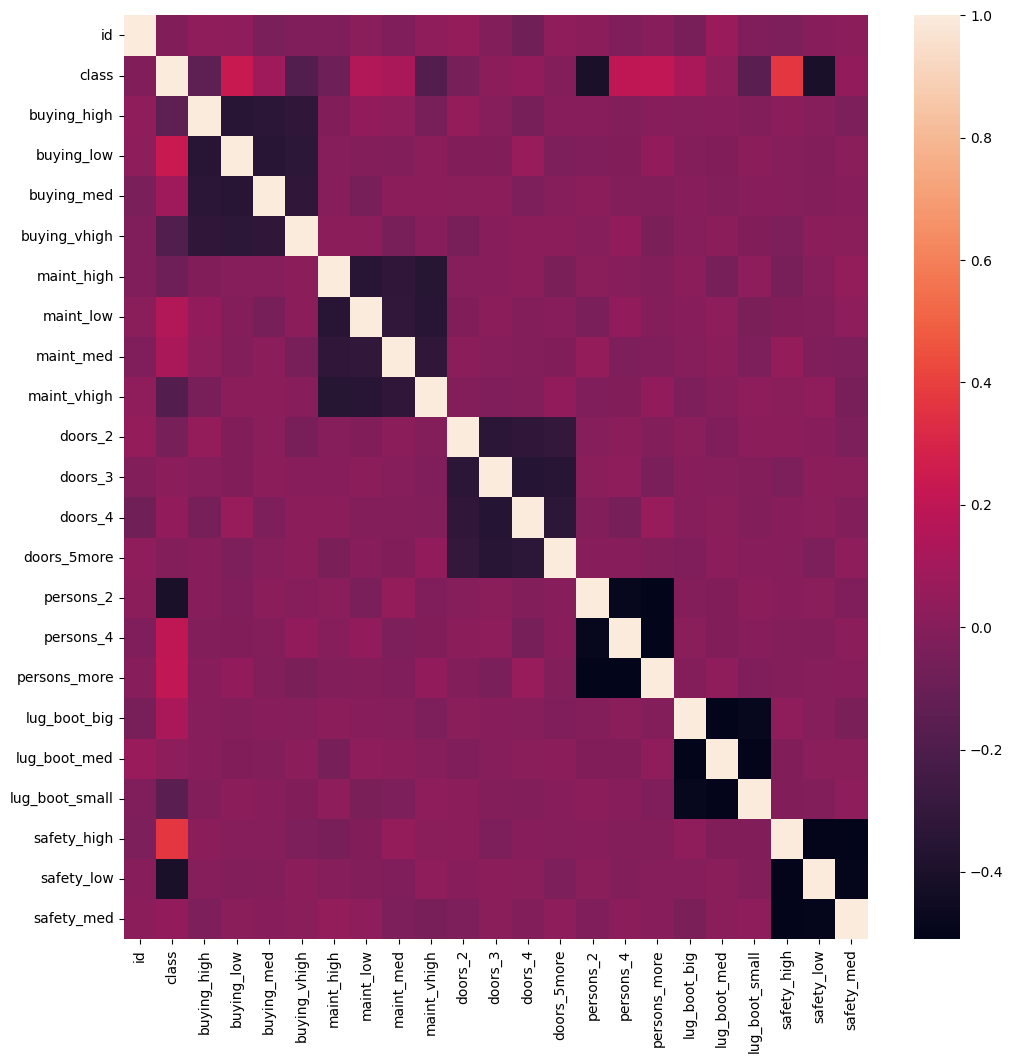

In [12]:
import seaborn as sns

plt.figure(figsize=(12,12))
sns.heatmap(df.corr())
plt.plot()

どのパラメータもclassに相関が結構でている。色が明るい＝正の相関、暗い＝負の相関、中間＝あまり相関なし

# 学習用データの準備
読み込んだデータをモデルへの入力データの形に実際に整える。正解がわかっているtrain.csvのデータは、学習に使うトレーニング用と学習自体には使わない検証(validation)用に分離して使用する。

In [13]:
from sklearn.model_selection import train_test_split

y = prepy(df)
x = prepx(df)

x_train, x_eval, y_train, y_eval = train_test_split(x, y, test_size = validation_split)

display(x_train, x_eval, y_train, y_eval)

,buying_high,buying_low,buying_med,buying_vhigh,maint_high,maint_low,maint_med,maint_vhigh,doors_2,doors_3,...,doors_5more,persons_2,persons_4,persons_more,lug_boot_big,lug_boot_med,lug_boot_small,safety_high,safety_low,safety_med
228,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
170,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
274,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
123,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
669,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
397,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
447,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


,buying_high,buying_low,buying_med,buying_vhigh,maint_high,maint_low,maint_med,maint_vhigh,doors_2,doors_3,...,doors_5more,persons_2,persons_4,persons_more,lug_boot_big,lug_boot_med,lug_boot_small,safety_high,safety_low,safety_med
14,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
459,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
758,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
146,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
163,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
769,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
452,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
477,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


,class_0,class_1,class_2,class_3
228,1.0,0.0,0.0,0.0
170,1.0,0.0,0.0,0.0
274,1.0,0.0,0.0,0.0
123,1.0,0.0,0.0,0.0
669,1.0,0.0,0.0,0.0
...,...,...,...,...
501,1.0,0.0,0.0,0.0
397,1.0,0.0,0.0,0.0
333,1.0,0.0,0.0,0.0
447,0.0,1.0,0.0,0.0


,class_0,class_1,class_2,class_3
14,0.0,1.0,0.0,0.0
459,1.0,0.0,0.0,0.0
758,1.0,0.0,0.0,0.0
146,1.0,0.0,0.0,0.0
163,1.0,0.0,0.0,0.0
...,...,...,...,...
375,0.0,1.0,0.0,0.0
769,0.0,1.0,0.0,0.0
452,1.0,0.0,0.0,0.0
477,1.0,0.0,0.0,0.0


# DNNで4クラス分類してみる
次のセルは、GPUが使える環境ならばメモリ拡張を有効にするおまじない。ただしColab環境であればランタイムのタイプをGPUに変更していないとGPUは有効にならない。しかしこの程度のサイズのモデルではGPUでなくても(デフォルトのCPUのままでも)あまり差が出ないので、特段変更しなくてもよい。

In [14]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) > 0:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
        print('{} memory growth: {}'.format(device, tf.config.experimental.get_memory_growth(device)))
else:
    print("Not enough GPU hardware devices available")

Not enough GPU hardware devices available


トレーニング時の表示やグラフの作成などの周辺カスタマイズの一例

In [15]:
import matplotlib.pyplot as plt
import datetime
from matplotlib.image import imread
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

# 表示をカスタマイズし、学習曲線をグラフ化するためのコールバック（例）
class MyCallback(Callback):
    def __init__(self):
        self.acc = []
        self.val_acc = []
        self.loss = []
        self.val_loss = []

        self.last_acc, self.last_val_acc = None, None
        self.last_loss, self.last_val_loss = None, None
        self.now_epoch, self.epochs = None, None
        self.best_val_loss, self.best_epoch = None, None

    def print_progress(self, epoch):
        epochs = self.epochs

        if self.last_val_acc and self.last_val_loss and self.best_val_loss:
            print("\rEpoch %d/%d -- loss: %f acc: %f - val_loss: %f val_acc: %f - best_val_loss: %f on Epoch %d" % (epoch+1, epochs, self.last_loss, self.last_acc, self.last_val_loss, self.last_val_acc, self.best_val_loss, self.best_epoch+1), end='')
        else:
            print("\rEpoch %d/%d -- loss: %f acc: %f" % (epoch+1, epochs, self.last_loss, self.last_acc), end='')

    def on_train_begin(self, logs={}):
        print('\n##### Train Start ##### ' + str(datetime.datetime.now()))
        self.epochs = self.params['epochs']
        self.params['verbose'] = 0
        self.best_epoch = None

    def on_epoch_begin(self, epoch, log={}):
        self.now_epoch = epoch

    def on_batch_end(self, batch, logs={}):
        self.last_acc = logs.get('acc') if logs.get('acc') else 0.0
        self.last_loss = logs.get('loss') if logs.get('loss') else 0.0

    def on_epoch_end(self, epoch, logs={}):
        self.acc.append(logs['acc'])
        self.val_acc.append(logs['val_acc'])
        self.loss.append(logs['loss'])
        self.val_loss.append(logs['val_loss'])
        epochs = range(len(self.loss))

        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()

        ax1.plot(epochs, self.acc, color = "blue", linestyle = "solid", linewidth = 1.0, label = 'train acc')
        ax1.plot(epochs, self.val_acc, color = "red", linestyle = "solid", linewidth = 1.0, label = 'valid acc')
        ax2.plot(epochs, self.loss, color = "blue", linestyle = "dotted" ,linewidth = 1.0, label = 'train loss')
        ax2.plot(epochs, self.val_loss, color = "red", linestyle = "dotted" , linewidth = 1.0, label= 'valid loss')
        ax2.set_yscale("log")
        ax1.set_ylim(0,1)
        ax1.grid(which='both')
        hd1, lb1 = ax1.get_legend_handles_labels()
        hd2, lb2 = ax2.get_legend_handles_labels()
        ax1.legend(hd1 + hd2, lb1 + lb2, loc = 'center right')
        plt.savefig(f'{tmpdir}/{outputname}.png')
        plt.clf()
        plt.close()

        self.last_val_acc = logs.get('val_acc') if logs.get('val_acc') else 0.0
        self.last_val_loss = logs.get('val_loss') if logs.get('val_loss') else 0.0
        update = False
        if not self.best_epoch or self.last_val_loss < self.best_val_loss:
            if self.best_epoch and epoch - self.best_epoch > 1:
                update = True
            self.best_val_loss = self.last_val_loss
            self.best_epoch = epoch
        self.print_progress(epoch)
        if update:
            print('')

    def on_train_end(self, logs={}):
        print('\n##### Train Complete ##### ' + str(datetime.datetime.now()))

        plt.axis('off')
        plt.imshow(imread(f'{tmpdir}/{outputname}.png'))

mycallback = MyCallback()

# val_loss値が最も小さいときの重みデータを保存するためのコールバック
weightfile = f'{tmpdir}/{outputname}.weights.h5'
checkpoint = ModelCheckpoint(
    weightfile,
    monitor = 'val_loss',
    save_best_only = True,
    save_weights_only = True,
    mode = 'min',
    verbose = 0,
)

# val_loss値が減らなくなったときにあきらめてストップさせるためのコールバック
early = EarlyStopping(
    monitor = 'val_loss',
    patience = earlystep,
    mode = 'min',
    verbose = 1,
)

## DNNモデルの作成

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout

# トレーニングデータ(x)を１次元化し、学習をランダムにドロップして過学習を予防しながら、何枚かのレイヤーでDNNを構成し、目的変数(y)に収束させる
# Denseのunit数を増やしたり、レイヤ枚数を増やすことで学習できるネットワークのサイズは大きくなっていく
model = Sequential()
model.add(Input(shape=(x.shape[1],1)))
model.add(Flatten())
model.add(Dropout(dropratio))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=y.shape[1], activation='softmax'))

from tensorflow.keras.optimizers import Adam

# 多値分類なので categorical_crossentropy でロスを計算する
# optimizerはいろいろな種類・パラメータがあるので調べてみるとよい
# 評価基準は Accuracy なので acc のmetricsを指定。ただしここを変えるとコールバックで見えるもの(acc)も変わるので注意
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(learning_rate = learning_rate),
    metrics = ['acc']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 21)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 21)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │              68 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 420 (1.64 KB)

 Trainable params: 420 (1.64 KB)

 Non-trainable params: 0 (0.00 B)

## トレーニング実行


##### Train Start ##### 2024-12-11 04:10:18.739310
Epoch 11/1000 -- loss: 0.849520 acc: 0.680174 - val_loss: 0.788133 val_acc: 0.682081 - best_val_loss: 0.788133 on Epoch 11
Epoch 147/1000 -- loss: 0.257599 acc: 0.908828 - val_loss: 0.208351 val_acc: 0.907514 - best_val_loss: 0.208351 on Epoch 147
Epoch 152/1000 -- loss: 0.231892 acc: 0.916064 - val_loss: 0.207068 val_acc: 0.901734 - best_val_loss: 0.207068 on Epoch 152
Epoch 172/1000 -- loss: 0.229408 acc: 0.916064 - val_loss: 0.190423 val_acc: 0.930636 - best_val_loss: 0.190423 on Epoch 172
Epoch 186/1000 -- loss: 0.220851 acc: 0.916064 - val_loss: 0.185386 val_acc: 0.936416 - best_val_loss: 0.185386 on Epoch 186
Epoch 203/1000 -- loss: 0.239717 acc: 0.908828 - val_loss: 0.184564 val_acc: 0.936416 - best_val_loss: 0.184564 on Epoch 203
Epoch 214/1000 -- loss: 0.233408 acc: 0.907381 - val_loss: 0.183055 val_acc: 0.942197 - best_val_loss: 0.183055 on Epoch 214
Epoch 222/1000 -- loss: 0.216329 acc: 0.911722 - val_loss: 0.179703 val_acc

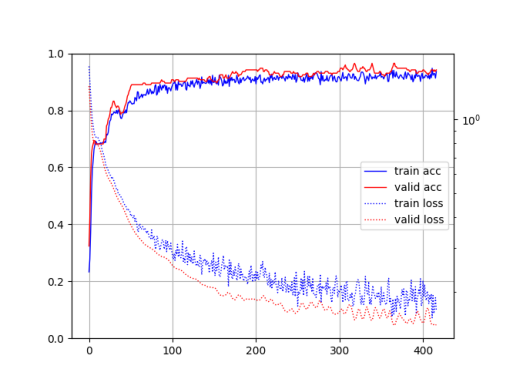

In [17]:
# コールバックを指定しつつ、トレーニングを実行する
hist = model.fit(x_train, y_train,
    epochs = epochs,
    batch_size = batch_size,
    validation_data = (x_eval, y_eval),
    callbacks = [mycallback, checkpoint, early],
    shuffle = True,
    verbose = 0,
)

# 途中でセーブされている、val_loss値がベストだった時の重みデータを読みなおす
model.load_weights(weightfile)

いかにしてval_lossを小さくしていくか、がポイント。0.1を切るとかなり良い学習ができている。val_lossが減らないのに、train時のlossがval_lossよりもどんどん下がっていくのが過学習状態で、多かれ少なかれは発生するものではあるが、あまりに早い段階でlossが下がりすぎる場合はdrop割合を増やしたり、レイヤーを複雑にしたりして学習率を調整する

## テストデータを読み、トレーニング済みのモデルにclassを推論させる

In [18]:
# テストデータを読み、xデータとして準備する
test = pd.read_csv(f'{datadir}/test.tsv', sep='\t')
tdf = prep(test)
x_test = prepx(tdf)

# モデルにかけて推論を実行する
p_test = model.predict(x_test)

p_test

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


array([[9.9999052e-01, 9.3859580e-06, 1.3101752e-11, 1.0222857e-12],
       [9.8174876e-01, 1.8250832e-02, 3.8861452e-07, 1.4788694e-09],
       [9.9999994e-01, 5.1003362e-08, 2.6526223e-13, 2.9422481e-15],
       ...,
       [9.9999326e-01, 6.7304672e-06, 7.9055764e-12, 5.9323010e-14],
       [9.9999768e-01, 2.2230836e-06, 1.3412701e-11, 1.6507753e-15],
       [9.9974000e-01, 2.5989709e-04, 3.7622282e-08, 1.2545893e-07]],
      dtype=float32)

モデルからは、4クラスそれぞれへの推論結果として合致可能性の値が出てくる。トレーニング時のloss値とはこのほかのクラスへの迷いのことで、lossが0.00なら断言レベルということ。testデータは正解がまだわからないのでloss値は計算できない

## 提出ファイルの形に編集して保存する
どういった編集が必要になるかはsample_submit.csvをよく眺め、pandasの操作などを調べて作っていく必要があります

In [19]:
# 4つの分類結果で最も大きな値(argmax)を答えにする
A = pd.DataFrame(np.argmax(p_test, axis=1), columns=['class'])

# 4クラスの数値から文字列に戻す
A['class'] = A['class'].map({0: 'unacc', 1: 'acc', 2: 'good', 3: 'vgood'})

# ID,classのファイル形式につなげなおし、csvファイルとして保存する
ANS = pd.concat([tdf['id'], A], axis=1)
ANS.to_csv(f'{datadir}/{outputname}_submit.csv', header=False, index=False)

ANS

,id,class
0,1,unacc
1,2,unacc
2,4,unacc
3,5,acc
4,6,unacc
...,...,...
859,1718,unacc
860,1719,unacc
861,1720,unacc
862,1723,unacc
